<a href="https://colab.research.google.com/github/GusMalija/Master-Thesis-Project-Augustine-Malija/blob/main/Baseline_SVM_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#calling important libraries
import pandas as pd #for data manipulation
import numpy as np #for data manipulation
import matplotlib as plt #for plotting
import os #for ease of python system interaction
import sys
import re
import nltk
import time
import dateutil
import seaborn as sns
nltk.download("stopwords")
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from datetime import datetime, date
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#retrieving the data
url = "https://raw.githubusercontent.com/GusMalija/Master-Thesis-Project-Augustine-Malija/main/Data/labeled_tweets_265_2021-04-23-trimmed.csv"

labeled_data = pd.read_csv(url)
#checking the dataset features
labeled_data.keys()
labeled_data.shape

(1329, 11)

In [3]:
#filtering out only relevant documents
relevant = labeled_data[labeled_data.relevant == 1]
relevant.head()

,Unnamed: 0,tweet__id,tweet__text,user__username,tag__title,relevant,2 - In favor,2 - Against,2 - Neutral,3 - Yes,time_annotated
0,0,1339644219015766016,JOB ALERT: Postdoctoral Opportunity: Climate C...,mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:56.815080+00:00
1,1,1189303279697780741,Whistleblower says CDC backed away from climat...,mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:49.298046+00:00
2,2,1088038576758104065,"Facing changes — in economics, climate change ...",mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:29.477801+00:00
3,3,1200848190028693504,"@CNN ...promoting ""Planetary emergency"" since ...",mala,Large sample of climate tweets 2,1,0,1,0,0,2021-04-01 20:23:21.248432+00:00
4,4,1314278326949892096,"Recourse, Greenpeace, Earthlife Africa and Cen...",mala,Large sample of climate tweets 2,1,1,0,0,1,2021-04-01 20:22:59.123097+00:00


In [4]:
#adding a new column that assigns 1 for in favor, 2 for against and 3 for neutral
conditions = [(relevant["2 - In favor"].eq(1)),
              (relevant["2 - Against"].eq(1)),
              (relevant["2 - Neutral"].eq(1)),]
choices = ["1","2","3"]
#adding a new column
relevant["classes"] = np.select(conditions, choices)

#filtering out zeros
relevant_not0 = relevant[relevant.classes != "0"]
relevant_not0.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Unnamed: 0,tweet__id,tweet__text,user__username,tag__title,relevant,2 - In favor,2 - Against,2 - Neutral,3 - Yes,time_annotated,classes
0,0,1339644219015766016,JOB ALERT: Postdoctoral Opportunity: Climate C...,mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:56.815080+00:00,3
1,1,1189303279697780741,Whistleblower says CDC backed away from climat...,mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:49.298046+00:00,3
2,2,1088038576758104065,"Facing changes — in economics, climate change ...",mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:29.477801+00:00,3
3,3,1200848190028693504,"@CNN ...promoting ""Planetary emergency"" since ...",mala,Large sample of climate tweets 2,1,0,1,0,0,2021-04-01 20:23:21.248432+00:00,2
4,4,1314278326949892096,"Recourse, Greenpeace, Earthlife Africa and Cen...",mala,Large sample of climate tweets 2,1,1,0,0,1,2021-04-01 20:22:59.123097+00:00,1


In [5]:
#checking for duplicates. Tweets that have errornously been multi-labeled
#calculate rowsums
relevant_not0["dup_check"] =relevant_not0[["2 - In favor", "2 - Against", "2 - Neutral"]].sum(axis=1)
#filter out greater than 1
duplicates = relevant_not0[relevant_not0.dup_check > 1] 
#only one tweet seems to be assigned to both in favor and against. 

#Dropping it since we are dealing with a multi-class problem
relevant_not0 = relevant_not0[relevant_not0.dup_check == 1]
relevant_not0.head()
#selecting only relevant columns
relevant_not0 = relevant_not0.drop(columns=["user__username", "tag__title","relevant", "2 - In favor", "2 - Against","2 - Neutral","3 - Yes", "Unnamed: 0","time_annotated", "dup_check"])
relevant_not0.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet__id,tweet__text,classes
0,1339644219015766016,JOB ALERT: Postdoctoral Opportunity: Climate C...,3
1,1189303279697780741,Whistleblower says CDC backed away from climat...,3
2,1088038576758104065,"Facing changes — in economics, climate change ...",3
3,1200848190028693504,"@CNN ...promoting ""Planetary emergency"" since ...",2
4,1314278326949892096,"Recourse, Greenpeace, Earthlife Africa and Cen...",1


In [6]:
#extracting only tweets as features
features = relevant_not0.iloc[:,1].values
#extracting labels
all_labels = relevant_not0.iloc[:,2].values
#removing dtype object
all_labels = np.array(all_labels, dtype='float')
all_labels

array([3., 3., 3., ..., 1., 3., 3.])

In [7]:
#preprocessing tweets
processed_features = []

for sentence in range(0, len(features)):   
    #Removing special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    #removing refered usernames
    processed_feature = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+|(\s([@#][\w_-]+)))"," ",processed_feature).split())
    #removing single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    #Removing single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    #Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    #Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    #removing @
    processed_feature = re.sub(r'@[\w]+','',processed_feature)
    #removing numbers
    processed_feature = re.sub(r'[0-9]+', '', processed_feature)
    # Removing hashtags
    processed_feature = re.sub(r'#\w*', ' ', processed_feature)
    #removing url
    processed_feature = re.sub(r"http\S+", "", processed_feature)
    #Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [8]:
#specifying parameters
parameters = [
    {
    'vect__max_df': (0.5,0.7,0.6), #ignore terms with frequency higher than aforementioned
        'vect__min_df': (3,5), #ignore lower frequencies than aforementioned
        'vect__ngram_range': ((1, 2),), #unigrams and bigrams
        'clf__estimator__kernel': ['rbf'], #gausian kernel
    'clf__estimator__gamma': [1e-1, 1e0, 1e1,], #a gamma of zero
        'clf__estimator__C': [1,2],
        'clf__estimator__class_weight': [None, "balanced"] #balanced weight
    } ,
    {
        'vect__max_df': (0.5,0.7,0.6),
        'vect__min_df': (3,5),
        'vect__ngram_range': ((1, 2),),
        'clf__estimator__kernel': ['linear'], #linear kernel
    'clf__estimator__C': [1,2]
    }
]

In [9]:
# building a pipeline
pipeline = Pipeline([('vect', TfidfVectorizer()),                     
    ('clf', OneVsRestClassifier(SVC(probability=True))),
])

In [10]:
#splitting the dataset to trian and test set
#80 percent of data for training, 20 percent for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, all_labels, test_size=0.4, random_state=42)

In [11]:
#grid search
grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, verbose=1)

In [12]:
#fitting the classifier
classifier = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  5.2min finished


In [13]:
#predicting
y_predict = classifier.predict(X_test)
#y_predict
#np.array(X_test)[(y_test == '1') & (y_predict == '1')]

In [14]:
#df = pd.DataFrame.from_dict(grid_search.cv_results_)
#df.head()
#df.sort_values("mean_test_score", ascending=False)

In [15]:
#confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))

[[124  26  22]
 [ 58  34   6]
 [ 63  17 127]]
              precision    recall  f1-score   support

         1.0       0.51      0.72      0.59       172
         2.0       0.44      0.35      0.39        98
         3.0       0.82      0.61      0.70       207

    accuracy                           0.60       477
   macro avg       0.59      0.56      0.56       477
weighted avg       0.63      0.60      0.60       477



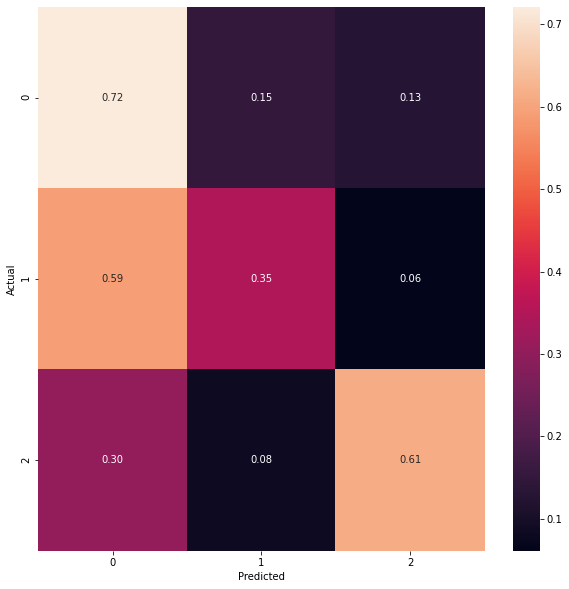

In [16]:
#normalizing a confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_predict)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [17]:
#evaluating the model with ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class="ovr")

#with a higher score than 0.5, signifies that our model is useful.

0.7700966141872013

In [18]:
#evaluating the model using cross validation
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)

#returning accuracies of the folds
print(all_accuracies)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.3min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.3min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.2min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.3min finished


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.4min finished


[0.52447552 0.5034965  0.54545455 0.6013986  0.53521127]


In [19]:
#printing standard deviation of accuracies
print(all_accuracies.std())

#earning a low variance meaning; a good indicator that the model will perform similar on all test sets and the prediction obtained is not by chance

0.03278975705833246


In [20]:
#tweets classified as "in favor" but predicted as "against"
np.array(X_test)[(y_test == '1') & (y_predict == '2')]
##tweets classified as "against" but predicted as "infavor"
np.array(X_test)[(y_test == '2') & (y_predict == '1')]
##tweets classified as "in favor" but predicted as "neutral"
np.array(X_test)[(y_test == '1') & (y_predict == '3')]
##tweets classfied as neutral but predicted as in favor
np.array(X_test)[(y_test == '3') & (y_predict == '1')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


array([], shape=(0, 477), dtype='<U833')

#Classified as in favor but predicted as against
Tweets containing words frequently used by climate change deniers. Even though 


they are in favor, they have been automatically classified as against as the example shows.

"seavoicenews climate change can believe that people really do call that hoax did they not go to school"

"iwashrren are you saying that climate change is hoax have read of this  co dmhthfnz if you can ignore the facts visual signs and the large majority of scientists you re lost"

Probably because it contains the word denial in it

"forest is on fire while everyone in denial of climate change poverty is growing an alarming rate while r stupefied by ambanis marriage card rate camels were shot down for drinking water for which there were no protests while there were protests when rapists were shot down"

Probably because it ends with a "no" right after it mentions addressing climate change. It aknowledges the impact humans have on the environment and the need to address climate change.

"snaftastic thehill mehdirhasan repaoc aoc yes humans have an impact on the environment drastically changing our society to address climate change no "

Not only is it reminding a denier not to attack a politician but also that climate change action is immediate

"hold_co aoc have you the take away here isn an opportunity to snipe at politician but the need to acknowledge the fact that climate change is an immediate concern"

Probably because it contains a strong word like pathetic, horror that is immaginable to be used in a denial sense

"pnpcbc rodphillips what pathetic excuse for avoiding admitting that climate change is happening"

"this is horror on very grand scale anyone who says there is no climate change must be completely mad"

Perhaps it's because it has a phrase "don't believe in climate change"

" pauldoroshenko mcfslaw even if you for whatever reason don believe in climate change it the wildest thing to me that people can watch this girl and somehow get outraged anyone angry out there willing to walk me through this what gives"

"truthseekeru meugeniamontiel charliekirk you re the one that that linked patrick moore m just debunking him again those names you keep throwing at me moore bastrati happer lindzen are the  of people or scientist that don believe in climate change believe the majority not the minority"

Probably because it has the word "global warming"

"aontuie toibin climate change is like rug on valium have you not noticed global warming has caused summer to become autumn"

###Humanly Hard to Annotate
Tweet defending a denier icon and defending ideas against climate change knowledge

"have you been drinking tonight did you honestly believe that think president trump is responsible for so called climate change that climate change is responsible for contagion outbreaks"

###Mistakenly annotated as in favor

"cogitoergosumau slayerofmemes frankwi pauldokidd granitereason erichschulz jwspry jagster matt_hew_jones shuangrove debunk the climate change hoax"

"barrynishizawa she wanted to burn his house down but that would contribute to climate change lmaoo"

###Obviously in favor tweets

"repdebhaaland trillions for climate change"

"dams were designed for time before climate change don hold up anymore"

"texasismyhomie jimmykimmel but climate change is actually real and not bronze age fairy tale"

"uber but for climate change"

#Classified as against but predicted as in favor
Probably because it contains the word greenpeace, sustainable, left

"greenpeace is fraud climate change is not dangerous at  ppm not even at"

"swedish scientist says humans should become cannibals to fight climate change because eating human flesh is more sustainable than the meat industry  co dvzggvoi via mailonline"

"skyrider peacethruhope these climate change idiots give me flu symptoms why does the left treat the country like we are brain free everyone of their policies are directly from this guy playbook who died in  clinton did thesis on this guy neversocialism  co hzvufj"

Probably because it mentions greta, although it is attacking her

" rachael_swindon jeremycorbyn gretathunberg theresa_may an elite agenda thats all climate change is lets look at the weather  years ago bad weather equals weather pattern today its climate change all this is driven by the elite whilst the sheeples follow look into it guys"

It mentions fighters against climate change but it is taking a stance against
"theemanfifty exactly what hypocrite barry gardiner is unfortunately many many of these so called fighters against climate change especially the liberal left are nothing more than hypocrites first second and third fourth etc they need to practice what they preach"


Perhaps because it has climate friendly words such as environmental protection and global cooperation.

"climate change is the biggest hoax created to justify globalization it different from environmental protection that everyone can do locally has to have global cooperation which never was there and never will be"

Perhaps because it mentions that poverty, hunger and technology have an impact on climate change.

"andrsil mandkdy gretathunberg perhaps she should be addressing poverty hunger and technology all of these have an influence on climate change stop mollycoddling this person encouraging school strikes is disgusting if take child out of school it unauthorised absence and get fined"

It's probably because it is sentimentally aknowledging the fatal effects of climate change

"yungvan climate change gonna kill us all anyway fuck it do what want"

Probably because it mentions donating money to fight climate change

"bezos donating b to address climate change feels like me dumping my garbage on my neighbor lawn for decade then offering to go halfsies on the cleanup while continuing to dump garbage on their lawn"

####Mistakenly Annotated as against
"while trump made headlines by withdrawing from the paris agreement obama era technocrats also defended corporate interests from more stringent and binding emissions targets that would have helped protect the entire world from climate disaster  co nizvmuqt"

"oooh look at the pretty lights in the ocean what amazing natural phenomenon wait it because the ocean is warming up and totally shouldn be due to climate change  co vmbnhfwq"
#Classified as In Favor but predicted as Neutral
Probably because it directs to a link even though it gives a stance

"climate change is the greatest health challenge we face in australia even after we recover from the coronavirus pandemic  co oqqhwwha"

Perhaps because it just questions the degree of denial

"realdonaldtrump you really don know anything about climate change do you"

Before clear annotation rules were developed, some tweets just giving information were annotated as in favor.

#Classified as Neutral but predicted as In Favor
Probably because it has the word climate change in it. Although it's not about climate change and does not take any stance.

"the new covid  earth observation dashboard allows users to track changes in air and water quality climate change economic activity and agriculture  co wdojunbyl eodata spacedata covid"

Perhaps it's because it is explaining how the farming innovation tackles climate change. Although the farmer seems to offer information

"davinde aprajitasarangi thanks am farmer have developed some veraity of paddy which produce germinated brown rice this is unique genetic paddy which is highly tolerance to climate change and also highelding highly nutritious and medicinal value am in search of finance for organic farming  co dskktnzli"

Perhaps because it explains what NASA admits. Even though the tweet is offerring information.

"nasa admits that climate change occurs because of changes in earth solar orbit and not because of suvs and fossil fuels  co uvfalmp  co fhzznyg"

Understanding Stance Drivers

In [21]:
#classified as against and predicted as against
np.array(X_test)[(y_test == '2') & (y_predict == '2')]
#classified as for and predicted as such
np.array(X_test)[(y_test == '1') & (y_predict == '1')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


array([], shape=(0, 477), dtype='<U833')